In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
%matplotlib inline

In [ ]:
df = pd.read_csv("./diabetes.csv")
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


Değişkenlerin herhangi birinde eksik veri olup olmadığını hızlı ve soyut bir şekilde kontrol etmek için basit bir df.info() çalıştırılır. Bu, boş olmayan değerlerin sayısını ve her değişkenin veri türünü listeler.

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Yukarıdaki gözlemimize göre değişkenlerin hiçbirinde eksik değer yok gibi görünmektedir. Ancak göründüğünden daha fazlası vardır. df.describe() Beş Sayı Özetini verirken bazı değişkenlerin minimum değerlerinin 0,0 olduğunu gösterecektir ki bu onların durumunda anlamsız olacaktır. Plazma glikoz konsantrasyonu, Diyastolik kan basıncı, Triceps deri kıvrım kalınlığı, 2 Saatlik serum insülini ve Vücut kitle indeksi sıfır olamaz.



In [ ]:
df.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
df.loc[df["Glucose"] == 0.0, "Glucose"] = np.NAN
df.loc[df["BloodPressure"] == 0.0, "BloodPressure"] = np.NAN
df.loc[df["SkinThickness"] == 0.0, "SkinThickness"] = np.NAN
df.loc[df["Insulin"] == 0.0, "Insulin"] = np.NAN
df.loc[df["BMI"] == 0.0, "BMI"] = np.NAN

df.isnull().sum()[1:6]

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Bu eksikliğin farkına varmanın daha iyi bir yolu, missingno paketini kullanarak bir boş matris çizerek aynı şeyi görselleştirmektir. Gözlemleyebildiğimiz üzere, Deri Kalınlığı ve İnsülin değişkenlerinin büyük bir kısmı yukarıda belirtilen sayıda kayıp veriye sahiptir. Çekirdeğimizi kısa tutmak için, daha fazla görselleştirme için sadece bu değişkenleri ele alacağım.



<Axes: >

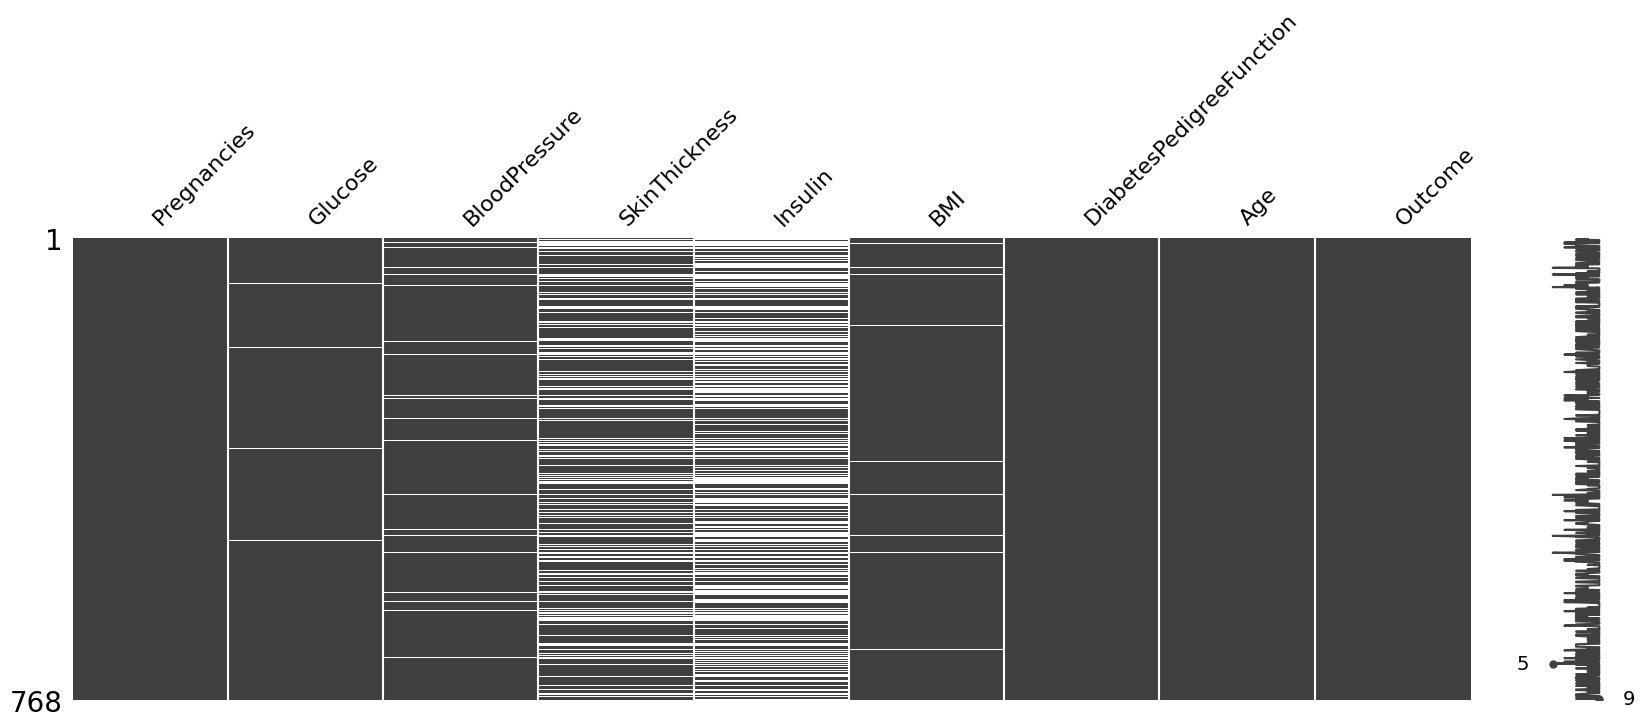

In [ ]:
mno.matrix(df, figsize = (20, 6))

Kayıp değerlere sahip birden fazla değişkenimiz olduğunda, tahmin edicilerin kendileri de kayıp veriler içerdiğinden, bunlardan birini impute etmek için doğrudan Regresyon İmputasyonunu kullanamayız. Ancak o zaman, bir değişkeni diğerine impute etmeden nasıl impute edebiliriz?

Bu Catch-22 durumundan, başlangıçta Basit Rastgele İmputasyon (eksik verileri değişkenin rastgele gözlenen değerleriyle impute ederiz) gibi bazı önemsiz yöntemler kullanarak eksik değerlere sahip tüm değişkenleri impute ederek ve daha sonra değişkenlerin her birinin yinelemeli olarak Regresyon İmputasyonu ile takip ederek kaçınabiliriz.

In [ ]:
missing_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]


Random_imputation işlevi, eksik değerleri değişkenin bazı rastgele gözlenen değerleriyle değiştirir. Yöntem, eksik değerler içeren tüm değişkenler için tekrarlanır ve ardından diğer değişken değerlerini tahmin etmek için regresyon modelinde parametre görevi görürler.

Basit Rastgele İmputasyon, mevcut diğer tüm verileri göz ardı ettiği için kaba yöntemlerden biridir ve bu nedenle çok nadir kullanılır. Ancak regresyon imputasyonu için iyi bir başlangıç noktası olarak hizmet eder.

In [ ]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)

    return df

In [ ]:
for feature in missing_columns:
    df[feature + '_imp'] = df[feature]
    df = random_imputation(df, feature)

Deterministik Regresyon İmputasyonunda, eksik verileri regresyon modelimizde tahmin edilen değerlerle değiştirir ve bu işlemi her değişken için tekrarlarız.

In [ ]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:

    deter_data["Det" + feature] = df[feature + "_imp"]
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})

    #Create a Linear Regression model to estimate the missing data
    model = linear_model.LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])

    #observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[df[feature].isnull(), "Det" + feature] = model.predict(df[parameters])[df[feature].isnull()]

<Axes: >

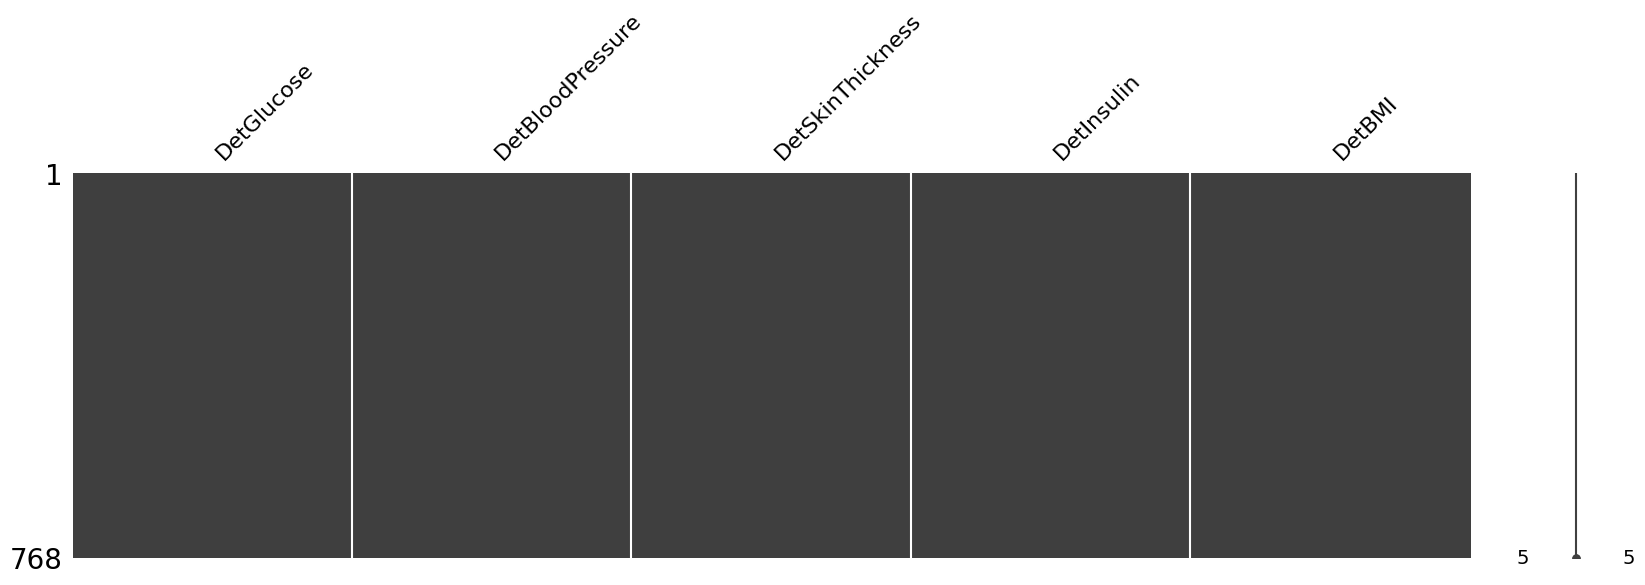

In [ ]:
mno.matrix(deter_data, figsize = (20,5))

Bu yöntemin en büyük dezavantajı, atanan değişkendeki doğal değişkenliği azaltmamızdır. Başka bir deyişle, eksik verileri regresyon çıktılarıyla değiştirdiğimiz için, tahmin edilen değerler değişkenin aslında bir miktar gürültü/yanlılık içereceği regresyon hiper düzlemi boyunca uzanır.

Yukarıdaki gerçeği birkaç şekilde görselleştirebiliriz. Bunlardan ilki, hem eksik veriler hem de tamamlanmış veriler için histogramlar çizerek, tamamlanmış verilerin grafiğinin eksik verilerinkine kıyasla daha uzun ve daha dar olduğunu gözlemleyebiliriz. Başka bir deyişle, tamamlanmış veri tamamlanmamış veriye göre daha az standart sapmaya (dolayısıyla daha az değişkenliğe) sahiptir.

Bir başka yöntem de, IQ Aralığının tamamlanmamış verilere kıyasla tamamlanmış veriler için oldukça sıkıştırılmış olduğunu gözlemleyebileceğimiz bir boxplot çizmektir.

<ipython-input-13-e2417a99dc32>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
<ipython-input-13-e2417a99dc32>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'red'

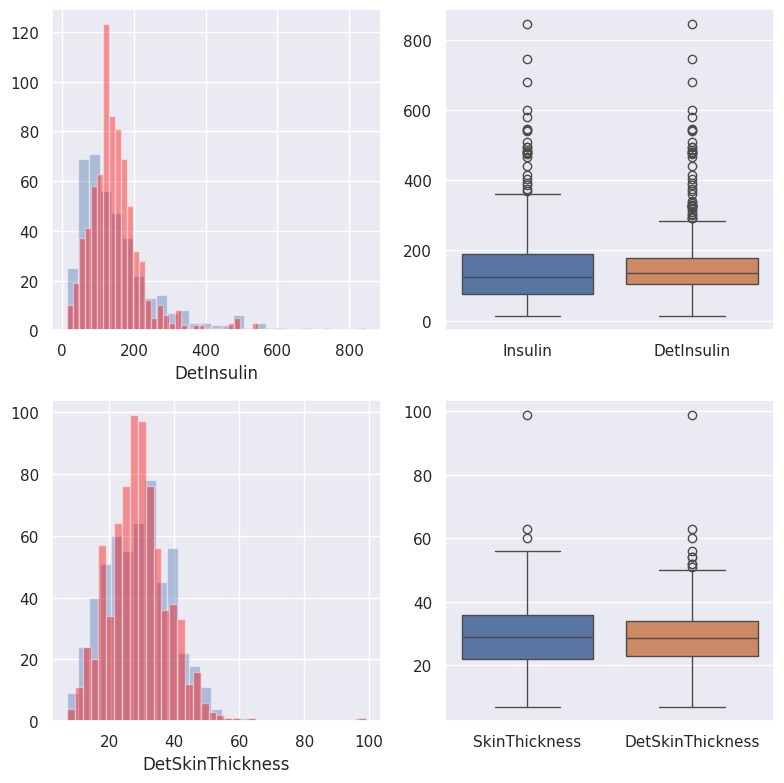

In [ ]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["Insulin", "SkinThickness"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'red')

    sns.boxplot(data = pd.concat([df[variable], deter_data["Det" + variable]], axis = 1),
                ax = axes[index, 1])

plt.tight_layout()

In [ ]:
pd.concat([df[["Insulin", "SkinThickness"]], deter_data[["DetInsulin", "DetSkinThickness"]]], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
Insulin,394.0,155.548223,118.775855,14.0,76.25,125.000000,190.000000,846.0
SkinThickness,541.0,29.153420,10.476982,7.0,22.00,29.000000,36.000000,99.0
DetInsulin,768.0,151.847367,88.698960,14.0,105.00,136.687715,179.043598,846.0
DetSkinThickness,768.0,28.948010,9.203058,7.0,23.00,28.535495,34.089716,99.0


Stokastik Regresyon İmputasyonu:

Atanan değişken değerlerine belirsizliği geri eklemek için, ortalaması sıfır ve varyansı regresyon tahminlerinin standart hatasına eşit olan normal dağılımlı bir miktar gürültü ekleyebiliriz. Bu yöntem Rastgele İmputasyon veya Stokastik Regresyon İmputasyonu olarak adlandırılır

In [ ]:
random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

for feature in missing_columns:

    random_data["Ran" + feature] = df[feature + '_imp']
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})

    model = linear_model.LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])

    #Standard Error of the regression estimates is equal to std() of the errors of each estimates
    predict = model.predict(df[parameters])
    std_error = (predict[df[feature].notnull()] - df.loc[df[feature].notnull(), feature + '_imp']).std()

    #observe that I preserve the index of the missing data from the original dataframe
    random_predict = np.random.normal(size = df[feature].shape[0],
                                      loc = predict,
                                      scale = std_error)
    random_data.loc[(df[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(df[feature].isnull()) & (random_predict > 0)]

Bu Gauss gürültüsünü eklediğimizde, belirli bir ortalama ve standart sapma çifti için dağılımın yayılması nedeniyle eksik veriler için bazı negatif değerler yükleyebiliriz. Ancak, daha önceki tartışmamıza göre, değerleri asla sıfır olamayacak bazı değişkenler olabilir. Örneğin, İnsülin konsantrasyonları için negatif bir değer anlamsız olacaktır.

Bu durumdan, yukarıda tartışılan basit rastgele imputasyonun getirdiği değerleri koruyarak kaçınabiliriz. Bu, görünüşe göre değişkenliği azaltır, ancak özellikle değerleri gerçek sayı doğrusunun belirli kısımlarıyla sınırlı olan bu değişkenler söz konusu olduğunda başa çıkmamız gereken bir şeydir.

<ipython-input-16-242fef576ae0>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
<ipython-input-16-242fef576ae0>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(random_data["Ran" + variable], kde = False, ax = axes[index, 0], color = 'red

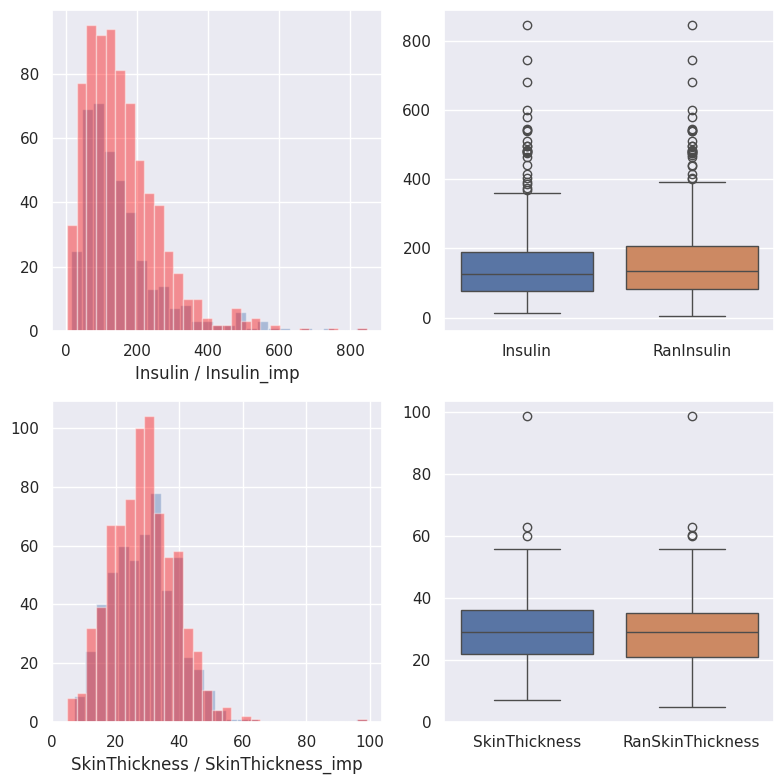

In [ ]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["Insulin", "SkinThickness"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(random_data["Ran" + variable], kde = False, ax = axes[index, 0], color = 'red')
    axes[index, 0].set(xlabel = variable + " / " + variable + '_imp')

    sns.boxplot(data = pd.concat([df[variable], random_data["Ran" + variable]], axis = 1),
                ax = axes[index, 1])

    plt.tight_layout()

Yukarıdaki grafiklerden, değişkenlere bir dereceye kadar değişkenlik kattığımızı ve doğal dağılımı da koruduğumuzu gözlemleyebiliriz.

In [ ]:
pd.concat([df[["Insulin", "SkinThickness"]], random_data[["RanInsulin", "RanSkinThickness"]]], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
Insulin,394.0,155.548223,118.775855,14.000000,76.250000,125.000000,190.000000,846.0
SkinThickness,541.0,29.153420,10.476982,7.000000,22.000000,29.000000,36.000000,99.0
RanInsulin,768.0,158.728599,107.793881,3.757719,82.000000,135.554757,207.493784,846.0
RanSkinThickness,768.0,28.760262,10.307955,4.673054,21.035881,29.000000,35.345572,99.0
